# Cropland extent maps for Africa

* **Products used:** 
[crop_mask_eastern](https://explorer.digitalearth.africa/crop_mask_eastern), 
[crop_mask_western](https://explorer.digitalearth.africa/crop_mask_western)


### Background

A central focus for governing bodies in Africa is the need to secure the necessary food sources to support their populations. It has been estimated that the current production of crops will need to double by 2050 to meet future needs for food production. Higher level crop-based products that can assist with managing food insecurity, such as cropping watering intensities, crop types, or crop productivity, require as a starting point precise and accurate cropland extent maps indicating where cropland occurs. Current cropland extent maps are either inaccurate, have coarse spatial resolutions, or are not updated regularly. An accurate, high-resolution, and regularly updated cropland area map for the African continent is therefore recognised as a gap in the current crop monitoring services.

Digital Earth Africa's cropland extent maps for East and West Africa shows the estimated location of croplands in the countries for the period January to Decemeber 2019:

* `crop_mask_eastern`: Tanzania, Kenya, Uganda, Ethiopia, Rwanda, and Burundi
* `crop_mask_western`: Nigeria, Benin, Togo, Ghana, Cote d'Ivoire, Liberia, Sierra Leone, Guinea, and Guinea-Bissau

For a full description of the product specifications, validation results, and methods used to develop the products, see the [Cropland_extent_specifications](https://docs.digitalearthafrica.org/en/latest/data_specs/Cropland_extent_specs.html) document. 


## Description

This notebook will
 
1.
2.


***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

The two sections below, "Loading, masking and visualizing pre-generated FC data" and "Calculating FC from Sentinel-2 surface reflectance" can be run independently.

### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline

import datacube
import xarray as xr
import matplotlib.pyplot as plt

from deafrica_tools.plotting import rgb, display_map


/env/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


### Connect to the datacube

Connect to the datacube so we can access DE Africa data.

In [2]:
dc = datacube.Datacube(app='cropland_extent')

### Analysis parameters

This section defines the analysis parameters, including 

* `lat, lon, buffer`: center lat/lon and analysis window size for the area of interest
* `time_period`: time period to be investigated

The default location is in a extensivley cultivated valley north of Addis Ababa, Ethiopia

In [35]:
lat, lon = 9.989, 39.228 #3.9779, 41.6454

buffer_lat, buffer_lon = 0.05, 0.05

time_period = ('2019')

resolution=(-10, 10)

#join lat,lon,buffer to get bounding box
lon_range = (lon - buffer_lon, lon + buffer_lon)
lat_range = (lat + buffer_lat, lat - buffer_lat)

## View the selected location

The next cell will display the selected area on an interactive map. Feel free to zoom in and out to get a better understanding of the area you'll be analysing. Clicking on any point of the map will reveal the latitude and longitude coordinates of that point.

In [36]:
display_map(lon_range, lat_range)

## List products available in Digital Earth Africa

We can use datacube's `list_products` functionality to inspect the Cropland extent products that are available. The table below shows the product name that we will use to load data.

In [37]:
dc_measurements.index[0]

('alos_palsar_mosaic', 'hh')

In [38]:
dc_measurements = dc.list_measurements()
dc_measurements.filter(like='crop_mask', axis=0)

name  dtype units  nodata  \
product           measurement                                  
crop_mask_eastern mask             mask  uint8     1     0.0   
                  prob             prob  uint8     1     0.0   
                  filtered     filtered  uint8     1     0.0   
crop_mask_western mask             mask  uint8     1     0.0   
                  prob             prob  uint8     1     0.0   
                  filtered     filtered  uint8     1     0.0   

                                         aliases flags_definition  
product           measurement                                      
crop_mask_eastern mask         [crop_mask, MASK]              NaN  
                  prob         [crop_prob, PROB]              NaN  
                  filtered                [mode]              NaN  
crop_mask_western mask         [crop_mask, MASK]              NaN  
                  prob         [crop_prob, PROB]              NaN  
                  filtered                [mode]              NaN

## Loading the crop mask


In [39]:
#generate a query object from the analysis parameters
query = {
    'time': time_period,
    'x': lon_range,
    'y': lat_range,
    'resolution':resolution
}

In [41]:
# load all available fc data
cm = dc.load(product='crop_mask_eastern',
             **query)
print(cm)

<xarray.Dataset>
Dimensions:      (time: 1, x: 966, y: 1257)
Coordinates:
  * time         (time) datetime64[ns] 2019-07-02T11:59:59.999999
  * y            (y) float64 1.274e+06 1.274e+06 ... 1.262e+06 1.262e+06
  * x            (x) float64 3.78e+06 3.78e+06 3.78e+06 ... 3.79e+06 3.79e+06
    spatial_ref  int32 6933
Data variables:
    mask         (time, y, x) uint8 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    prob         (time, y, x) uint8 71 68 66 71 86 85 83 ... 79 83 61 59 61 67
    filtered     (time, y, x) uint8 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 0 0 0
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref


Above, we can see the crop_mask product contains three measurements:

   * `mask`: This band displays cropped regions as a binary map. Values of `1` indicate the presence of crops, while a value of `0` indicates the absence of cropping. This band is a _pixel-based_ cropland extent map, meaning the map displays the raw output of the pixel-based Random Forest classification.
   
   * `prob`: This band displays the prediction probabilities for the 'crop' class. As this service uses a random forest classifier, the prediction probabilities refer to the percentage of trees that voted for the random forest classification. For example, if the model had 200 decision trees in the random forest, and 150 of the trees voted 'crop', the prediction probability is **150 / 200 x 100 = 75 %**. Thresholding this band at > 50 % will produce a map identical to `mask`. 
   
   * `filtered`: This band displays cropped regions as a binary map. Values of `1` indicate the presence of crops, while a value of `0` indicates the absence of cropping. This band is an _object-based_ cropland extent map where the `mask` band has been filtered using an image segmentation algorithm (see [this paper](https://www.mdpi.com/2072-4292/6/7/6111/htm) for details on the algorithm used). During this process, segments smaller than 1 Ha (100 10m x 10m pixels) are merged with neighbouring segments, resulting in a map where the smallest classified region is 1 Ha in size. The `filtered` dataset is provided as a complement to the `mask` band; small commission errors are removed by object-based filtering, and the 'salt and pepper' effect typical of classifying pixels is diminished.  
   
Below, we will plot the three measurements side-by-side

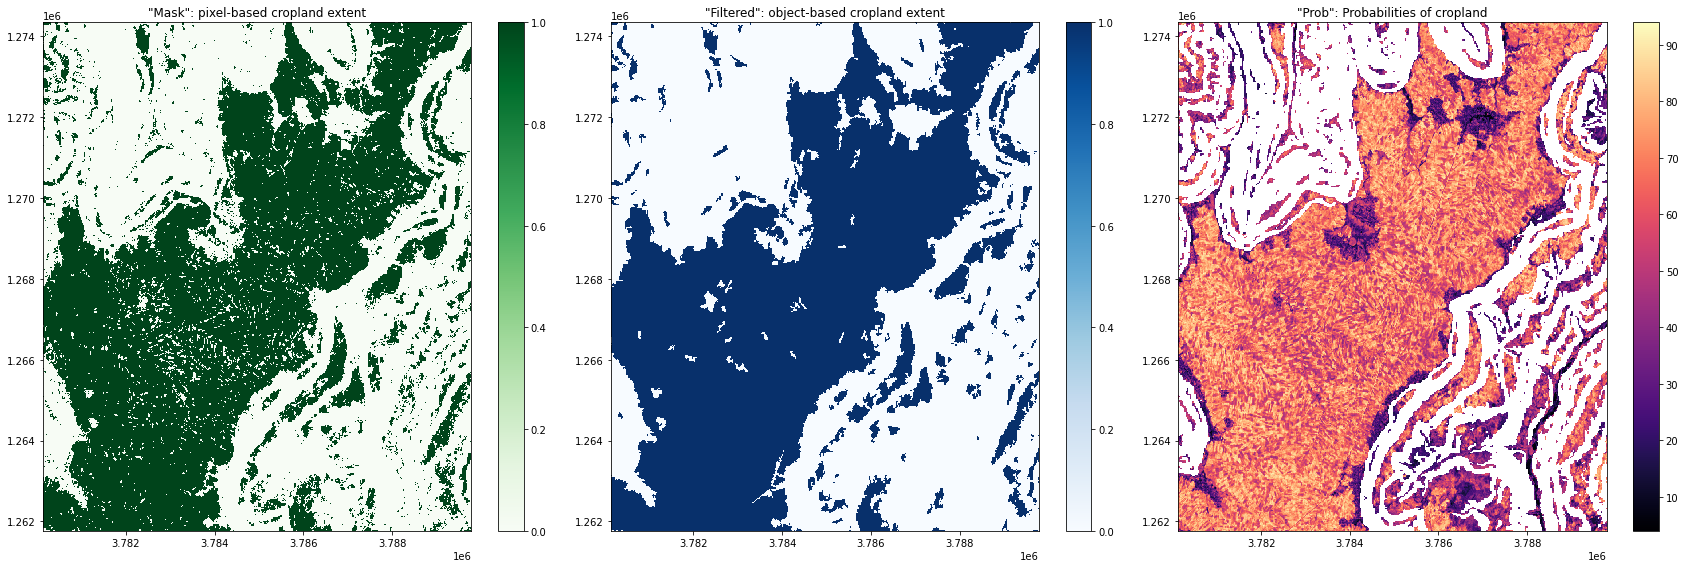

In [76]:
fig, axes = plt.subplots(1, 3, figsize=(24, 8))
cm.mask.plot(ax=axes[0], 
                   cmap='Greens', 
                   add_labels=False)

cm.filtered.plot(ax=axes[1], 
                   cmap='Blues', 
                   add_labels=False)

cm.prob.where(cm.prob>0).plot(ax=axes[2], 
                   cmap='magma', 
                   add_labels=False)

axes[0].set_title('"Mask": pixel-based cropland extent')
axes[1].set_title('"Filtered": object-based cropland extent')
axes[2].set_title('"Prob": Probabilities of cropland');

plt.tight_layout();

## Example application: 

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to repoart an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:**

In [16]:
print(datacube.__version__)

1.8.5


**Last Tested:**

In [17]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2021-09-16'